In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import statsmodels
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import talib
import backtrader as bt
import datetime as dt
from binance.client import Client
import pandas as pd
import seaborn as sns
import calendar
import talib


<font size="5">取得五個貨幣商品 '2021/01/01 ~ 2023/12/31' 的15分Ｋ交易歷史資料</font>

In [1529]:
## 得到資料集
client = Client("", "")
symbol_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BNBUSDT', 'SOLUSDT']
data = {}
start_str = dt.datetime.strptime('2021-01-01 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")
end_str = dt.datetime.strptime('2023-12-31 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")

## 取得資料（定義商品、K線週期）
for symbol in symbol_list:
    ## 設定取得資料的時間單位
    interval = Client.KLINE_INTERVAL_15MINUTE
    tmp_data = client.futures_historical_klines(symbol, interval, start_str, end_str)
    tmp_data= pd.DataFrame(tmp_data, columns= ['Open Time', 'Open Price', 'High Price', 'Low Price', 'Close Price',
                                               'Volume', 'Kline Close Time', 'Quote Asset Volume', 'Number of Trades', 
                                    'Base Asset Volume', 'Quote Asset Volume', 'Unuset Field'] )
    ## 將時間戳轉為 UTC+0
    tmp_data['Open Time']= tmp_data['Open Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    tmp_data['Kline Close Time']= tmp_data['Kline Close Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    
    ## 將價格欄位的資料型態從 str -> float
    tmp_data['Open Price']= tmp_data['Open Price'].astype(float)
    tmp_data['Close Price']= tmp_data['Close Price'].astype(float)
    tmp_data['High Price']= tmp_data['High Price'].astype(float)
    tmp_data['Low Price']= tmp_data['Low Price'].astype(float)
    tmp_data['Volume']= tmp_data['Volume'].astype(float)
    
    ## 處理欄位名稱
#     tmp_data['Open Time']= pd.to_datetime(tmp_data['Open Time'])
#     tmp_data.set_index('Open Time', inplace=True)
#     tmp_data.rename(columns={'Open Price': 'open', 'High Price': 'high', 'Low Price': 'low', 'Close price': 'close', 
#                    'Volume': 'volume'}, inplace=True)
    
    data[symbol] = tmp_data
    
## 新增欄位星期幾、月份、年
US_Open = pd.to_datetime('09:30:00').time()
US_Close = pd.to_datetime('16:00:00').time()

for symbol in symbol_list:
    data[symbol]['Weekday']= data[symbol]['Open Time'].apply(lambda x:  calendar.day_name[dt.datetime.strptime(x.split()[0] ,'%Y-%m-%d').weekday()])
    data[symbol]['Month']= data[symbol]['Open Time'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
    data[symbol]['Year']= data[symbol]['Open Time'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
    data[symbol]['US_Market']= data[symbol]['Open Time'].apply(lambda x:1 if US_Open <= pd.to_datetime(x).time() <= US_Close else 0)


<font size="5">以BTCUSDT為範例，列出 2021/01/01 ~ 2023/12/31 15分K線的歷史資料</font>

In [1530]:
data['BTCUSDT']

,Open Time,Open Price,High Price,Low Price,Close Price,Volume,Kline Close Time,Quote Asset Volume,Number of Trades,Base Asset Volume,Quote Asset Volume,Unuset Field,Weekday,Month,Year,US_Market
0,2021-01-01 00:00:00,28948.19,29045.93,28706.00,28786.75,3181.960,2021-01-01 00:14:59,91834596.81370,24166,1277.389,36899008.19096,0,Friday,1,2021,0
1,2021-01-01 00:15:00,28786.92,28902.68,28752.30,28859.28,2215.315,2021-01-01 00:29:59,63865195.40455,17044,1209.372,34869765.90905,0,Friday,1,2021,0
2,2021-01-01 00:30:00,28860.00,28968.49,28859.99,28947.61,1153.678,2021-01-01 00:44:59,33369604.08775,12208,620.757,17954267.70655,0,Friday,1,2021,0
3,2021-01-01 00:45:00,28947.61,29055.00,28910.94,29015.00,1486.635,2021-01-01 00:59:59,43095200.76748,12524,876.324,25408134.95831,0,Friday,1,2021,0
4,2021-01-01 01:00:00,29015.00,29499.00,28975.46,29446.35,7476.067,2021-01-01 01:14:59,218765516.96528,45858,4619.428,135213638.57443,0,Friday,1,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105020,2023-12-30 23:00:00,42167.30,42279.90,42131.30,42265.60,1861.855,2023-12-30 23:14:59,78606372.19450,24716,1201.143,50713198.93210,0,Saturday,12,2023,0
105021,2023-12-30 23:15:00,42265.50,42335.20,42248.20,42271.00,848.028,2023-12-30 23:29:59,35865420.09140,11615,510.411,21587093.91880,0,Saturday,12,2023,0
105022,2023-12-30 23:30:00,42271.10,42293.80,42190.10,42216.70,809.453,2023-12-30 23:44:59,34194255.75840,11759,303.899,12838364.85240,0,Saturday,12,2023,0
105023,2023-12-30 23:45:00,42216.60,42256.70,42160.70,42174.20,1107.110,2023-12-30 23:59:59,46733165.26790,12210,450.158,19004970.04520,0,Saturday,12,2023,0


<font size="5">視覺化商品貨幣的價格波動度，以20天的ATR值除以收盤價，得到價格波動的百分比。</font>

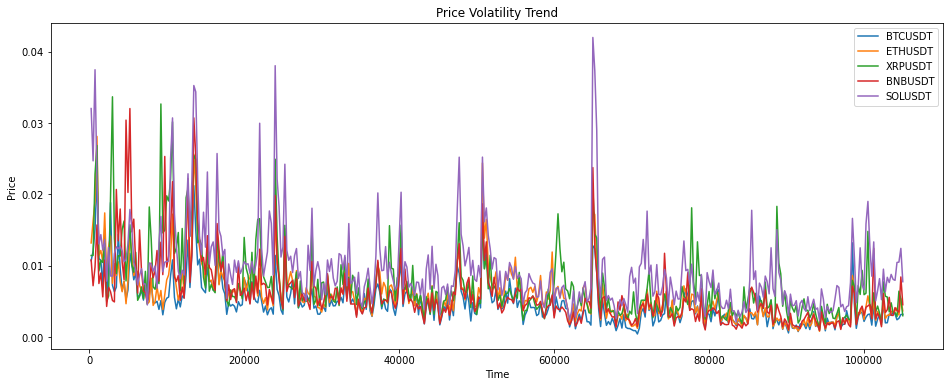

In [1562]:
## 以ATR指標跟蹤給定時間段內的商品價格波動率，並除以收盤價（標準化價格變動的比率）
ATR= {}
for symbol in symbol_list:
    ATR[symbol] = talib.ATR(data[symbol]['High Price'].values, 
                                  data[symbol]['Low Price'].values, 
                                  data[symbol]['Close Price'].values, timeperiod=20)/ data[symbol]['Close Price']
    ATR= pd.DataFrame(ATR)
    
# ATR['Year']= data['BTCUSDT']['Year']
## 將五個貨幣商品的相對波動度視覺化 ##
# 由於資料集過於龐大，故將ATR的波動變化每250筆取一次歷史價格

plt.figure(figsize=(16, 6))
for symbol in symbol_list:
    plt.plot( ATR[symbol][[x for x in range(0, len(ATR[symbol]), 250)]],   label= symbol)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Volatility Trend')
plt.legend()
plt.show()

<font size="5">由上圖可知，五個商品貨幣中，其中'SOLUSDT'的價格波動度最大，  
    
假設交易策略是以較短時間內價格的高波動來獲利，可提高商品:'SOLUSDT'的佔比權重</font>

In [1564]:
## 五個虛擬幣，不同年分的交易量佔比

symbol_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BNBUSDT', 'SOLUSDT']
data['BTCUSDT'].groupby('Month')['Volume'].sum().tolist()
total_vol= {}
for symbol in symbol_list:
#     total_vol.append(data[symbol]['Volume'].sum())
    total_vol[symbol]= data[symbol].groupby('Year')['Volume'].sum()
    total_vol= pd.DataFrame(total_vol)
#     plt.plot(data[symbol].groupby('Month')['Volume'].sum().tolist())
#     plt.plot(data['ETHUSDT'].groupby('Month')['Volume'].sum().tolist())
# total_vol
# plt.pie(total_vol,  autopct='%1.1f%%', startangle=220)
total_vol
total_vol.divide(total_vol.sum(axis=1), axis=0) *100
# total_vol

,BTCUSDT,ETHUSDT,XRPUSDT,BNBUSDT,SOLUSDT
Year,,,,,
2021,0.020235,0.156111,98.885984,0.220312,0.717359
2022,0.037066,0.345377,97.600348,0.126674,1.890535
2023,0.025736,0.193851,97.393558,0.092880,2.293975


<font size="5">上方圖表為五個商品貨幣的交易量佔比</font>  

<font size="4">由圖表可得知，無論哪個年度，'XRPUSDT'的交易量佔比皆為第一，  
表示此貨幣的市場流動性高，能夠更快速反應整體市場的波動。</font>  



<font size="5">視覺化美股市場開市與休市對虛擬貨幣交易量與價格波動的影響 </font>  


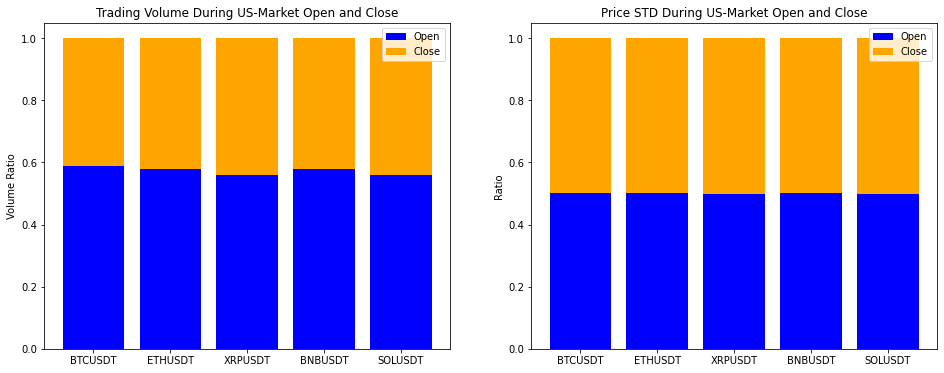

In [1565]:
symbol_list
US_vol= { 'Crypto': [], 'Open': [], 'Close': []}
open_market= []
close_market= []
for symbol in symbol_list:
    ## 計算數據在美股開市與休市，兩個類別的總交易量
    us_market_sum = data[symbol].groupby('US_Market')['Volume'].sum() 
    
    ## 計算數據在美股開市或休市，兩個類別的總筆數
    us_market_len = data[symbol]['US_Market'].value_counts() 
    
    ## 將總交易量除以總比數，得到兩個類別每一筆交易時段的平均交易量佔比
    us_market_vol= us_market_sum/ us_market_len 
    US_vol['Crypto'].append(symbol)
    US_vol['Open'].append( round(us_market_vol[1]/ us_market_vol.sum(), 2))
    US_vol['Close'].append( round(us_market_vol[0]/ us_market_vol.sum(), 2))
        
US_vol= pd.DataFrame(US_vol)

US_std= {'Crypto': [], 'Open': [], 'Close': []}
for symbol in symbol_list:
    ## 計算數據在美股開市與休市，兩個類別的價格標準差
    std= data[symbol].groupby('US_Market')['Close Price'].std()
    US_std['Crypto'].append(symbol)
    US_std['Open'].append(std[1]/ std.sum())
    US_std['Close'].append(std[0]/ std.sum())
    
US_std= pd.DataFrame(US_std)


## 將五個貨幣商品在美股開市與休市期間的交易量畫圖並比較
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
colors = ['blue', 'orange']
plt.bar(US_vol['Crypto'], US_vol['Open'], color=colors[0], label='Open')
plt.bar(US_vol['Crypto'], US_vol['Close'], bottom=US_vol['Open'], color=colors[1], label='Close')
plt.ylabel('Volume Ratio')
plt.title('Trading Volume During US-Market Open and Close')
plt.legend()



## 計算五個貨幣商品在美股開市與休市期間的價格標準差，並畫圖並比較
plt.subplot(1, 2, 2)
colors = ['blue', 'orange']
plt.bar(US_std['Crypto'], US_std['Open'], color= colors[0], label='Open')
plt.bar(US_std['Crypto'], US_std['Close'], bottom= US_std['Open'], color=colors[1], label='Close')
plt.ylabel('Ratio')
plt.title('Price STD During US-Market Open and Close')

plt.legend()
plt.show()

<font size="5">上圖為美股開市與休市，對交易量與價格波動的比較圖</font>  

<font size="4">由左上圖可知，五個商品貨幣，美股開市時段的交易量皆大於美股休市的時段，    
商品貨幣交易量的高流動性，可能會增加技術分析指標的準確性，  
故美股開市時，推薦使用以技術分析面所觸發交易訊號的策略，並回測後衡量績效。  
    由右上圖可知，五個商品貨幣中，無論是美股開市或休市，對商品貨幣價格的波動無顯著性的影響</font>

<font size="5">視覺化商品貨幣以 '星期' 為單位的交易量變化與價格波動度</font>  


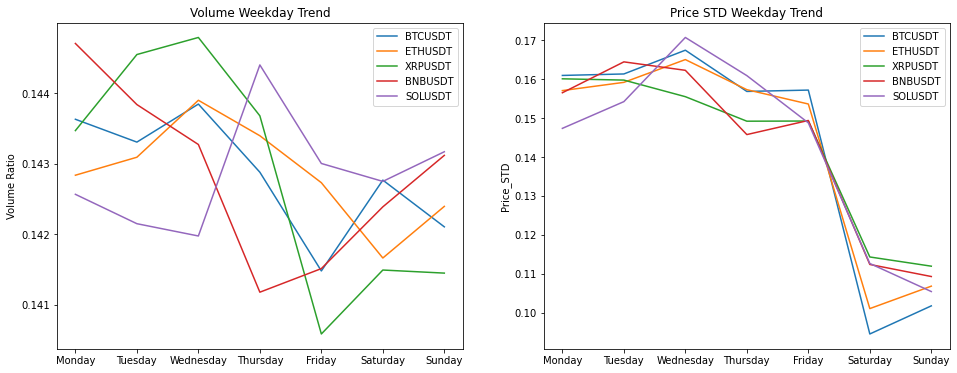

In [1570]:
## 計算五個商品，每個月份的價格標準差 ##
weekly_order= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

week_vol= {}
for symbol in symbol_list:
    std= data[symbol].groupby('Weekday')['Close Price'].std()
    week_vol[symbol]= std
    
week_vol = pd.DataFrame(week_vol)
week_vol= week_vol.reindex(weekly_order)
  
price_week_std= {}
for symbol in symbol_list:
    std= data[symbol].groupby('Weekday')['Volume'].sum()
    price_week_std[symbol] = std

    price_week_std= pd.DataFrame(price_week_std)
price_week_std= price_week_std.reindex(weekly_order)

## 將每個欄位的值除以哪一個欄位的總和，標準化數值

column_sums= week_vol.sum()
week_vol = week_vol.div(column_sums, axis= 1)

column_sums= price_week_std.sum()
price_week_std = price_week_std.div(column_sums, axis=1)

## 視覺化每個月份的價格標準差
# 第一張圖
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for symbol in symbol_list:
    plt.plot(week_vol[symbol] , label= symbol)

plt.ylabel('Volume Ratio')
plt.title('Volume Weekday Trend')
plt.legend()

# 第二張圖
plt.subplot(1, 2, 2)
for symbol in symbol_list:
    plt.plot(price_week_std[symbol] , label= symbol)

plt.ylabel('Price_STD')
plt.title('Price STD Weekday Trend')
plt.legend()
plt.show()

<font size="5">  上方圖片為各個星期的價格波動與交易量  
</font>  

<font size="4">五個商品貨幣中，交易量並無顯著的影響，沒有明顯的趨勢，  
    價格的波動度則是在週六與週日有顯著性的降低。</font>

<font size="5">  視覺化商品貨幣以 '月份' 為單位的交易量變化與價格波動度 
</font> 

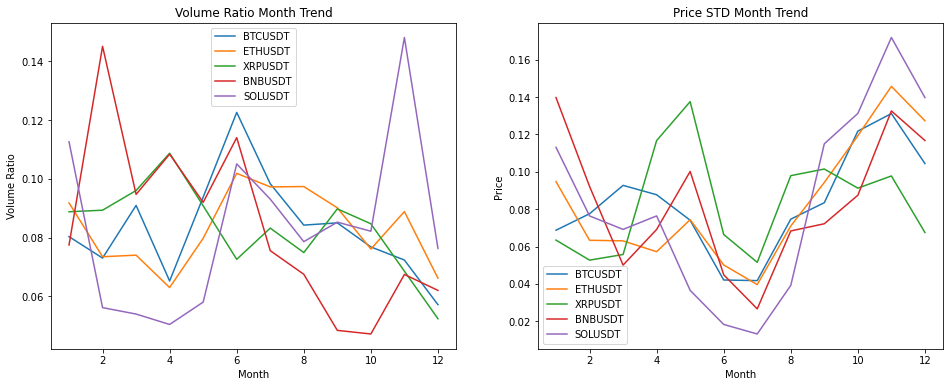

In [1569]:
## 計算五個商品，每個月份的交易量與價格標準差 ##
year_vol= {}
for symbol in symbol_list:
    year_vol[symbol]= data[symbol].groupby('Month')['Volume'].sum() 

year_vol= pd.DataFrame(year_vol)

price_mon_std= {}
for symbol in symbol_list:
    std= data[symbol].groupby('Month')['Close Price'].std()
    price_mon_std[symbol] = std

price_mon_std= pd.DataFrame(price_mon_std)

## 將每個欄位的值除以哪一個欄位的總和，標準化數值
column_sums= year_vol.sum()
year_vol = year_vol.div(column_sums, axis=1)
column_sums= price_mon_std.sum()
price_mon_std = price_mon_std.div(column_sums, axis=1)

## 繪製圖型
# 第一張圖
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for symbol in symbol_list:
    plt.plot(year_vol[symbol] , label= symbol)
    
plt.xlabel('Month')
plt.ylabel('Volume Ratio')
plt.title('Volume Ratio Month Trend')
plt.legend()

# 第二張圖
plt.subplot(1, 2, 2)
for symbol in symbol_list:
    plt.plot(price_mon_std[symbol] , label= symbol)

plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Price STD Month Trend')
plt.legend()
plt.show()

<font size="5">上方圖片為各月份對交易量以及價格波動的趨勢圖。</font>  

<font size="4"> 在12月時，五個商品貨幣的價格波動皆提高，但只有'SOLUSDT'的交易量顯著上升，  
當商品貨幣的價格波動降低，也並無顯著影響交易量的大小</font>  
  
  

<font size="5">視覺化商品貨幣以 '年份' 為單位的交易量變化與價格波動度</font>  


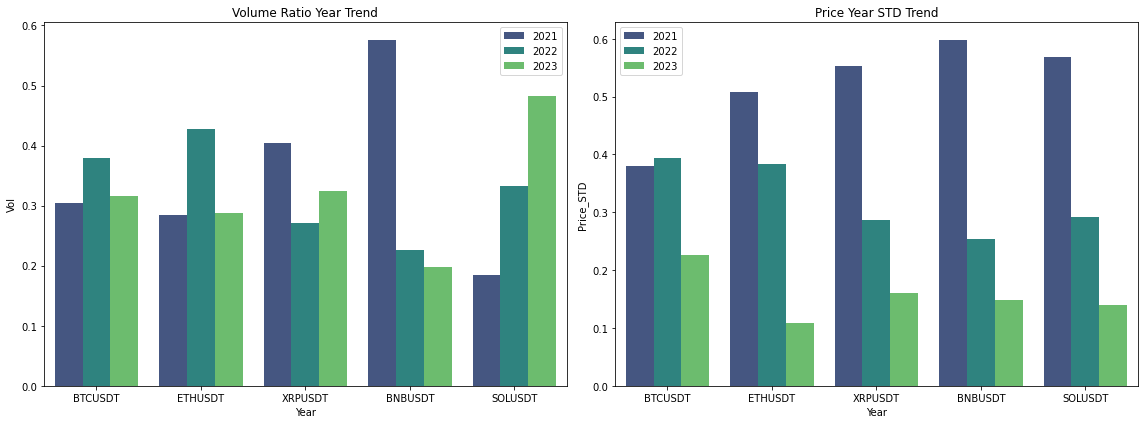

In [1571]:
## 獲取五個商品貨幣在2021～2023年交易量與價格的變化
year_vol= {}
for symbol in symbol_list:
    year_vol[symbol]= data[symbol].groupby('Year')['Volume'].sum() 

year_vol= pd.DataFrame(year_vol)

price_std= {}
for symbol in symbol_list:
    std= data[symbol].groupby('Year')['Close Price'].std()
    price_std[symbol]= std
    
price_std= pd.DataFrame(price_std)

## 將每個欄位的值除以哪一個欄位的總和，標準化數值
column_sums= price_std.sum()
price_std = price_std.div(column_sums, axis=1)
price_std = price_std.reset_index()

column_sums= year_vol.sum()
year_vol = year_vol.div(column_sums, axis=1)
year_vol = year_vol.reset_index()

## 將資料進行長格式（long format）的轉換
year_vol = pd.melt(year_vol, id_vars='Year', var_name='Crypto', value_name='Value')
price_std = pd.melt(price_std, id_vars='Year', var_name='Crypto', value_name='Value')


## 使用 Seaborn 的 barplot 繪製堆疊長條圖
# 第一張圖
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)  # 1 表示1行，2 表示2列，1 表示第1個子圖
sns.barplot(data= year_vol, x='Crypto', y='Value', hue='Year', palette='viridis')

plt.xlabel('Year')
plt.ylabel('Vol')
plt.title('Volume Ratio Year Trend')
plt.legend()

# 第二張圖
plt.subplot(1, 2, 2)  # 1 表示1行，2 表示2列，2 表示第2個子圖
sns.barplot(data= price_std, x='Crypto', y='Value', hue='Year', palette='viridis')

plt.xlabel('Year')
plt.ylabel('Price_STD')
plt.title('Price Year STD Trend')
plt.legend()

plt.tight_layout()  # 自動調整子圖的佈局，以避免重疊

plt.show()

<font size="5"> 上方圖片為各年度對價格波動與交易量的趨勢圖    </font> 
    
<font size="4">由左上圖可知，五個商品貨幣中，'SOLUSDT'的交易量顯著逐年提高，  
而'BNBUSDT'的交易量則是2021年交易量占比最高，  
其餘三個商品貨幣2021~2023年的交易占比無顯著差異  
  
由右上圖可知，五個商品貨幣的價格在2021年的波動皆大於2022、2023年，  
可理解為市場在2021年的短期波動較大，而這一兩年的市場較為穩定或是低迷。</font>

<font size="5"> 獲取五個商品貨幣 2021/01 ~ 2022/12這段時間日K線的歷史價格    </font> 


In [1573]:
## 獲取五個商品貨幣 2021/01 ~ 2022/12這段時間日K線的歷史價格

client = Client("", "")
symbol_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BNBUSDT', 'SOLUSDT']
data = {}
start_str = dt.datetime.strptime('2021-01-01 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")
end_str = dt.datetime.strptime('2022-12-31 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")

## 取得資料（定義商品、K線週期）
for symbol in symbol_list:
    ## 設定取得資料的時間單位
    interval = Client.KLINE_INTERVAL_1DAY
    tmp_data = client.futures_historical_klines(symbol, interval, start_str, end_str)
    tmp_data= pd.DataFrame(tmp_data, columns= ['Open Time', 'Open Price', 'High Price', 'Low Price', 'Close Price',
                                               'Volume', 'Kline Close Time', 'Quote Asset Volume', 'Number of Trades', 
                                    'Base Asset Volume', 'Quote Asset Volume', 'Unuset Field'] )
    ## 將時間戳轉為 UTC+0
    tmp_data['Open Time']= tmp_data['Open Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    tmp_data['Kline Close Time']= tmp_data['Kline Close Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    
    ## 將價格欄位的資料型態從 str -> float
    tmp_data['Open Price']= tmp_data['Open Price'].astype(float)
    tmp_data['Close Price']= tmp_data['Close Price'].astype(float)
    tmp_data['High Price']= tmp_data['High Price'].astype(float)
    tmp_data['Low Price']= tmp_data['Low Price'].astype(float)
    tmp_data['Volume']= tmp_data['Volume'].astype(float)

    data[symbol] = tmp_data.iloc[:, 0:6]


<font size="5"> 以'BTCUSDT'為例，列出 '2021/01/01~ 2022/12/31'的歷史價格資料   </font> 

In [1574]:
data['BTCUSDT']

,Open Time,Open Price,High Price,Low Price,Close Price,Volume
0,2021-01-01 00:00:00,28948.19,29668.86,28627.12,29337.16,210716.398
1,2021-01-02 00:00:00,29337.15,33480.00,28958.24,32199.91,545541.080
2,2021-01-03 00:00:00,32198.41,34832.25,32000.02,33054.53,487486.989
3,2021-01-04 00:00:00,33053.93,33653.56,27800.00,32031.07,506128.023
4,2021-01-05 00:00:00,32029.55,34500.00,29900.00,33999.52,433720.833
...,...,...,...,...,...,...
725,2022-12-27 00:00:00,16912.80,16968.00,16580.00,16698.20,262828.564
726,2022-12-28 00:00:00,16698.20,16778.30,16455.60,16539.00,344649.858
727,2022-12-29 00:00:00,16538.90,16659.00,16485.10,16630.30,208591.531
728,2022-12-30 00:00:00,16630.30,16666.60,16320.00,16601.20,295630.490


<font size="5"> 獲取五個商品貨幣的每日收盤價    </font> 


In [1413]:
## 獲取五個商品貨幣的每日收盤價
stra= {}
for symbol in symbol_list:
    stra[symbol] = data[symbol]['Close Price']
    
stra= pd.DataFrame(stra)

## 計算每日收益率，並刪除缺失值
stra_pct= stra.pct_change().dropna()
stra_pct

,BTCUSDT,ETHUSDT,XRPUSDT,BNBUSDT,SOLUSDT
1,0.097581,0.062006,-0.070257,0.012594,-0.022087
2,0.026541,0.264793,0.024887,0.079146,0.210892
3,-0.030963,0.064137,0.042384,-0.003826,0.140809
4,0.061454,0.055776,-0.043626,0.015969,-0.140021
5,0.083065,0.101109,0.102303,0.011699,-0.121845
...,...,...,...,...,...
725,-0.012694,-0.013262,0.005198,0.009252,-0.021015
726,-0.009534,-0.017634,-0.032118,-0.008519,-0.120682
727,0.005520,0.008757,-0.038245,0.006955,-0.013848
728,-0.001750,-0.000575,0.007895,-0.001544,0.027356


<font size="5"> 計算相關性矩陣，並以熱力圖呈現交互關係。    </font> 


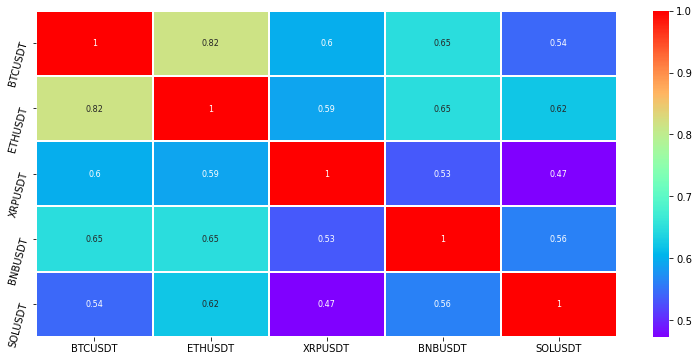

In [1417]:
corr_matrix= stra_pct.iloc[:, 0:5].corr()

## 將相關性矩陣用熱力圖呈現
plt.figure(figsize=(13, 6))
sns.heatmap(corr_matrix,annot=True,cmap='rainbow',linewidths=1.0,annot_kws={'size':8})
plt.yticks(rotation=75)
plt.show()

<font size="5"> 計算共變異數矩陣，並列出表格    </font> 


In [1572]:
cov_mat = stra_pct.iloc[:, 0:5].cov()

## 轉為年化共變異數矩陣
cov_mat_annual = cov_mat * 365
cov_mat_annual


,BTCUSDT,ETHUSDT,XRPUSDT,BNBUSDT,SOLUSDT
BTCUSDT,0.535284,0.588565,0.550882,0.560732,0.589519
ETHUSDT,0.588565,0.972876,0.733878,0.754238,0.909158
XRPUSDT,0.550882,0.733878,1.581345,0.791095,0.881869
BNBUSDT,0.560732,0.754238,0.791095,1.392572,0.984993
SOLUSDT,0.589519,0.909158,0.881869,0.984993,2.199525


<font size="5"> 用蒙地卡羅模擬，隨機生成K個權重，並計算其波動率與收益率   </font> 

In [1420]:
## 設定模拟的參數

K = 10000  # 進行K次模擬
day= 365 # 一年的交易日天數

# 设置空的numpy数组，儲存每次模擬的權重、收益率與波動率
random_p = np.empty((K, 7))

np.random.seed(7)

stra_pct= stra.pct_change().dropna()

for i in range(K):

    random5=np.random.random(5)
    random_weight=random5/np.sum(random5)

    #计算年平均收益率
    mean_return=stra_pct.mul(random_weight,axis=1).sum(axis=1).mean()
    annual_return=(1+mean_return)** day- 1

    #计算年化標準差 (波动率)
    random_volatility=np.sqrt(np.dot(random_weight.T, np.dot(cov_mat_annual,random_weight)))

    #将上面生成的权重，和计算得到的收益率、标准差存入数组random_p中
    random_p[i][:5]=random_weight
    random_p[i][5]=annual_return
    random_p[i][6]=random_volatility
    
RandomPortfolios=pd.DataFrame(random_p)
RandomPortfolios.columns=[symbol[0:3]  for symbol in symbol_list]+['Returns','Volatility']

RandomPortfolios

,BTC,ETH,XRP,BNB,SOL,Returns,Volatility
0,0.025469,0.260312,0.146327,0.241470,0.326422,2.847510,1.022231
1,0.286436,0.266555,0.038325,0.142788,0.265897,1.644245,0.916302
2,0.306236,0.362372,0.171750,0.029728,0.129913,1.056336,0.869991
3,0.359352,0.084302,0.178620,0.367890,0.009837,1.282482,0.870962
4,0.185435,0.293377,0.071112,0.169360,0.280717,1.990493,0.949637
...,...,...,...,...,...,...,...
9995,0.156108,0.265200,0.329268,0.173179,0.076245,1.513445,0.922987
9996,0.038595,0.053227,0.462669,0.111148,0.334362,2.658013,1.073377
9997,0.243749,0.222627,0.020162,0.325682,0.187780,1.892822,0.920726
9998,0.069477,0.296875,0.149721,0.425254,0.058674,2.146353,0.953729


<font size="5">表格為隨機生成K=10000個，五種貨幣的權重組合以及收益率與波動率</font>  


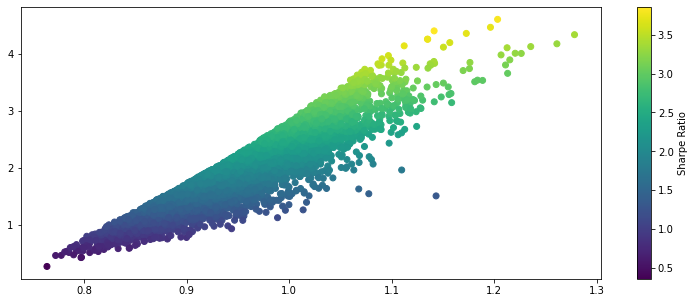

In [1421]:
## 設定無風險利率為 0
risk_free = 0

## 計算每個組合的夏普比率

RandomPortfolios['Sharpe'] = (RandomPortfolios.Returns - risk_free) / RandomPortfolios.Volatility

# 绘制收益-标准差的散点图，并用颜色描绘夏普比率

plt.figure(figsize=(13, 5))
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, c=RandomPortfolios.Sharpe)
plt.colorbar(label='Sharpe Ratio')
plt.show()

<font size="5">上圖為收益-標準差的散點圖，並用顏色區別夏普比率 </font> 


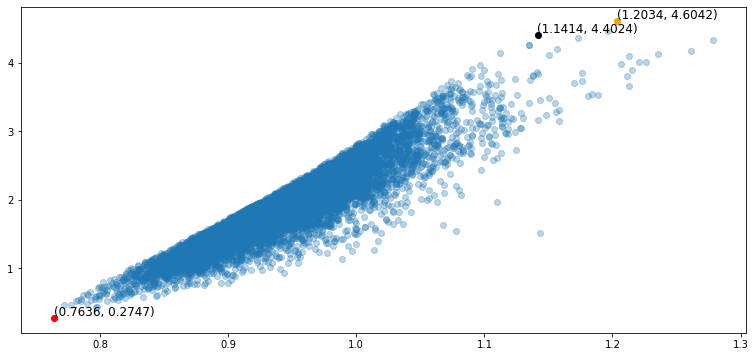

In [1422]:
## 繪製散點圖，視覺化資料

min_index= RandomPortfolios.Volatility.idxmin()
max_index= RandomPortfolios.Returns.idxmax()
sharpe_max_index= RandomPortfolios.Sharpe.idxmax()

## 每一個點代表一個投資組合，左下紅點為風險最低之組合，右上紅點為收益最高之組合，黑點為夏普比率最大之組合

plt.figure(figsize=(13, 6))
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, alpha=0.3)

x = RandomPortfolios.loc[min_index,'Volatility']
y = RandomPortfolios.loc[min_index,'Returns']
plt.scatter(x, y, color='red')
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=12)
x = RandomPortfolios.loc[sharpe_max_index,'Volatility']
y = RandomPortfolios.loc[sharpe_max_index,'Returns']
plt.scatter(x, y, color='black')
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=12)
x = RandomPortfolios.loc[max_index,'Volatility']
y = RandomPortfolios.loc[max_index,'Returns']
plt.scatter(x, y, color='orange')
plt.text(np.round(x,4),np.round(y,4),(np.round(x,4),np.round(y,4)),ha='left',va='bottom',fontsize=12)

plt.show()

<font size="5">每一個點代表一個投資組合</font>  
<font size="4">
* 左下紅點為風險最低之組合  
    
* 右上橘點為收益最高之組合   
    
- 黑點為夏普比率最大之組合</font>  

In [1501]:
## 把上述權重組合存儲下來，並新增Equal Weight組合

weights_combine=  RandomPortfolios.iloc[[ min_index, max_index, sharpe_max_index], 0:5]#.to_list()
weights_combine
weights_combine.rename(index={2331: 'Volatility Min', 2175: 'Returns Max', 9130: 'Sharpe Ratio'}, inplace= True)
weights_combine.loc['Equal Weights'] = np.repeat(0.2, 5)
weights_combine

,BTC,ETH,XRP,BNB,SOL
Volatility Min,0.745042,0.068587,0.150235,0.010275,0.025861
Returns Max,0.027218,0.038971,0.018033,0.298915,0.616863
Sharpe Ratio,0.017863,0.012779,0.046860,0.457569,0.464929
Equal Weights,0.200000,0.200000,0.200000,0.200000,0.200000


<font size="5">上述表格為每一個權重組合的值，共有四個權重組合</font>  
  
  <font size="5">以2023年的歷史資料，代入這四個投資組合的權重，評估哪一個投資策略的績效最為突出。  
</font>  



<font size="5"> 獲取五個商品貨幣 '2023/01/01 ~ 2022/12/31' 這段時間日K線的歷史價格   </font> 

In [1577]:
## 獲取五個商品 2021/01 ~ 2022/12這段時間日K線的歷史價格
## 得到資料集
client = Client("", "")
symbol_list = ['BTCUSDT', 'ETHUSDT', 'XRPUSDT', 'BNBUSDT', 'SOLUSDT']
data = {}
start_str = dt.datetime.strptime('2023-01-01 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")
end_str = dt.datetime.strptime('2023-12-31 00:00:00', '%Y-%m-%d %H:%M:%S').strftime("%d %b %Y %H:%M:%S")

## 取得資料（定義商品、K線週期）
for symbol in symbol_list:
    ## 設定取得資料的時間單位
    interval = Client.KLINE_INTERVAL_1DAY
    tmp_data = client.futures_historical_klines(symbol, interval, start_str, end_str)
    tmp_data= pd.DataFrame(tmp_data, columns= ['Open Time', 'Open Price', 'High Price', 'Low Price', 'Close Price',
                                               'Volume', 'Kline Close Time', 'Quote Asset Volume', 'Number of Trades', 
                                    'Base Asset Volume', 'Quote Asset Volume', 'Unuset Field'] )
    ## 將時間戳轉為 UTC+0
    tmp_data['Open Time']= tmp_data['Open Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    tmp_data['Kline Close Time']= tmp_data['Kline Close Time'].apply(lambda x : dt.datetime.utcfromtimestamp(x//1000).strftime('%Y-%m-%d %H:%M:%S'))
    
    ## 將價格欄位的資料型態從 str -> float
    tmp_data['Open Price']= tmp_data['Open Price'].astype(float)
    tmp_data['Close Price']= tmp_data['Close Price'].astype(float)
    tmp_data['High Price']= tmp_data['High Price'].astype(float)
    tmp_data['Low Price']= tmp_data['Low Price'].astype(float)
    tmp_data['Volume']= tmp_data['Volume'].astype(float)

    data[symbol] = tmp_data.iloc[:, 0:6]


## 將資料轉換為為backtrader 可接受的格式

for symbol in data:
    data[symbol]['Open Time']= pd.to_datetime(data[symbol]['Open Time'])
    data[symbol].set_index('Open Time', inplace=True)
    data[symbol].rename(columns={'Open Price': 'open', 'High Price': 'high', 'Low Price': 'low', 'Close Price': 'close', 
                   'Volume': 'volume'}, inplace=True)
    for col in data[symbol].iloc[:, 0:4]:
        data[symbol][col] = data[symbol][col].astype(float)
        
data['BTCUSDT']

,open,high,low,close,volume
Open Time,,,,,
2023-01-01,16537.5,16618.8,16488.0,16610.3,105502.965
2023-01-02,16610.4,16799.0,16541.2,16666.0,215161.176
2023-01-03,16665.9,16774.0,16600.3,16667.2,203070.205
2023-01-04,16667.3,16984.6,16645.7,16842.1,349747.838
2023-01-05,16842.2,16872.8,16740.4,16823.8,176369.347
...,...,...,...,...,...
2023-12-27,42538.6,43700.0,42145.7,43453.8,251351.538
2023-12-28,43453.8,43850.0,42320.5,42600.1,257515.182
2023-12-29,42600.1,43171.9,41283.2,42095.1,337421.865


<font size="5">以'BTCUSDT'作為範例， 上述表格為2023一整年的歷史交易資料。</font>  


<font size="5">撰寫交易策略，分析2021~2022年的歷史價格，得到不同權重組合，  
      
根據2023年的資料做回測，每十五天再平衡倉位的佔比，評估各權重組合的績效。</font>  

In [1586]:
class MyStrategy(bt.Strategy):
    params= (
        ('weights', {'BTC': 0.2, 'ETH':0.2, 'XRP':0.2, 'BNB':0.2, 'SOL':0.2,}), ## 預設權重皆相等
        
        ('rebalance_day', 15) ## 設定15天再平衡
    )
    def __init__(self):
        
        self.count= 0 ## 用於計天數
        self.values = []
        
    def next(self):
        
        self.count+= 1
        
        self.values.append(self.broker.getvalue() )
        
        # 每15個交易日重新平衡投資組合
        
        if self.count % self.p.rebalance_day ==0:
            

            cash = self.broker.get_cash()
            value = self.broker.getvalue()
#             print(f"可運用資金: {round(cash, 2)}, 總資產: {round( value , 2)}")


            for i, d in enumerate(self.datas):
                # 獲取當前的投資組合價值
                total_value = self.broker.getvalue() 

                # 計算每個商品應持有的價值
                weight_price= total_value* self.p.weights[d._name]

                # 計算當前的商品價格
                current_price= d.close[0] 

                # 計算每個商品應該持有的數量
                weight_quant= weight_price / current_price 

                # 獲取當前的庫存數量
                current_quant= self.getposition(d).size

                 # 計算商品需調整的數量，大於0，代表需買入該數量
                adj_quant= round(weight_quant - current_quant)

                # 執行調整操作

                if adj_quant!= 0:
                    
                    if adj_quant >0 :
                        self.buy(data= d, size= adj_quant)
                        
                    else:
                        sell_order= self.sell(data= d, size= adj_quant)
                        
#         if self.count == 365:
#             for i , d in enumerate(self.datas):
#                 value= d.close[0] * self.getposition(d).size / self.broker.getvalue()
#                 print(f'貨幣名稱: {d._name} , 目前權重佔比: {round(value , 4)}' 
#                       f'  設定權重佔比: {round(self.p.weights[d._name], 4)}, 差額: {round(self.p.weights[d._name] -value, 4)}')
#             print('-----------------------------------')


In [1587]:

# 將 DataFrame 轉換為 Backtrader 資料源
data_BTC = bt.feeds.PandasData(dataname= data['BTCUSDT'].iloc[: , 0:5])#, timeframe=bt.TimeFrame.Minutes, compression= 30)
data_ETH = bt.feeds.PandasData(dataname= data['ETHUSDT'].iloc[: , 0:5])#, timeframe=bt.TimeFrame.Minutes, compression= 30)
data_XRP = bt.feeds.PandasData(dataname= data['XRPUSDT'].iloc[: , 0:5])#, timeframe=bt.TimeFrame.Minutes, compression= 30)
data_BNB = bt.feeds.PandasData(dataname= data['BNBUSDT'].iloc[: , 0:5])#, timeframe=bt.TimeFrame.Minutes, compression= 30)
data_SOL = bt.feeds.PandasData(dataname= data['SOLUSDT'].iloc[: , 0:5])#, timeframe=bt.TimeFrame.Minutes, compression= 30)


initial_Capital= 2000000
Portfolio= {}

for weight in range(len(weights_combine)):

    cerebro= bt.Cerebro()
    # 添加資料
    cerebro.adddata(data_BTC, name= 'BTC')
    cerebro.adddata(data_ETH, name= 'ETH')
    cerebro.adddata(data_XRP, name= 'XRP')
    cerebro.adddata(data_BNB, name= 'BNB')
    cerebro.adddata(data_SOL, name= 'SOL')


    # 添加策略
    cerebro.addstrategy(MyStrategy, weights= dict(weights_combine.iloc[weight, :]))
    
    cerebro.addobserver(bt.observers.Broker)

    # 設定起始資金
    cerebro.broker.set_cash(initial_Capital)

    # 設定手續費
    cerebro.broker.setcommission(commission=0.001)

    # 启动回测引擎
    cerebro.run()
    Portfolio[weight]= cerebro.runstrats[0][0].values
    
Portfolio= pd.DataFrame(Portfolio, index= data['BTCUSDT'].index)
Portfolio.columns= weights_combine.index.to_list()
Portfolio

,Volatility Min,Returns Max,Sharpe Ratio,Equal Weights
Open Time,,,,
2023-01-01,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
2023-01-02,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
2023-01-03,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
2023-01-04,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
2023-01-05,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
...,...,...,...,...
2023-12-27,4.109724e+06,6.821733e+06,5.394094e+06,4.194282e+06
2023-12-28,4.040972e+06,6.618537e+06,5.269928e+06,4.126722e+06
2023-12-29,3.992268e+06,6.762171e+06,5.326036e+06,4.103083e+06


<font size="5">表格為四種組合權重，追蹤每一天的資產總價值</font>  


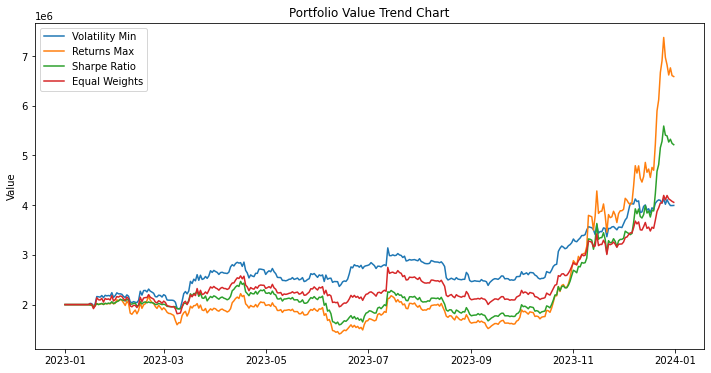

In [1588]:
plt.figure(figsize=(12, 6))
for column in Portfolio.columns:
    plt.plot(Portfolio[column], label=column)

plt.title('Portfolio Value Trend Chart')
plt.ylabel('Value')
plt.legend()  # 添加圖例顯示每個類別
plt.show()

<font size="5">上圖為四種投資組合的價值趨勢圖</font>  
  
  <font size="4">可以看到在這四種權重組合中，以'Returns Max'的投資組合最終的回報率最大，  
    'Sharpe Ratio'雖然收益不如第一種組合，但在風險調整後仍然表現較好，  
    但此投資組合大部分的權重都在於'SOLUSDT'，也是仰賴於此貨幣商品，這組合權重的投資績效才可飆升，  
    'Equal Weights'的組合表現則與'Volatility Min'相當。  
  
需要注意的是，這樣的權重組合僅基於過去的資料，未來市場環境可能有所不同。  
    在制定投資策略應考慮更多方面因素，需加入更多的影響因子來分析市場行情，  
    並把交易策略設定的更為完善，例如以機器學習的方式來產生交易訊號。</font>  



In [1605]:
## 四種投資權重組合如下
weights_combine

,BTC,ETH,XRP,BNB,SOL
Volatility Min,0.745042,0.068587,0.150235,0.010275,0.025861
Returns Max,0.027218,0.038971,0.018033,0.298915,0.616863
Sharpe Ratio,0.017863,0.012779,0.046860,0.457569,0.464929
Equal Weights,0.200000,0.200000,0.200000,0.200000,0.200000


<font size="5">四種投資組合的報酬率如下</font>  

In [1604]:
Portfolio.tail(1).apply(lambda x: (x- initial_Capital)/initial_Capital)

,Volatility Min,Returns Max,Sharpe Ratio,Equal Weights
Open Time,,,,
2023-12-31,0.997323,2.293706,1.608147,1.028582
